In [1]:
#!pip3 install neat-python

from keras.datasets import mnist
import numpy as np
import ssl
import neat
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:463: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:464: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:465: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

## Global Parameters

In [2]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 10

RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

# How many samples to test:
N_SAMPLES_TO_TEST = 100

# Simulation Parameters
NR_GENERATIONS = 300
CONFIG_FILE = 'NEAT-configs/config-feedforward-weight-agnostic-half-and-half'

## Load MNIST

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## Preprocess MNIST

### Trim down Dataset

In [4]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 60000
Testing samples remaining: 10000


### Rescale Images

In [5]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

### Normalize

In [6]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small
X_train_norm = normalize(X_train_small)
X_test_norm = normalize(X_test_small)

### Visualize

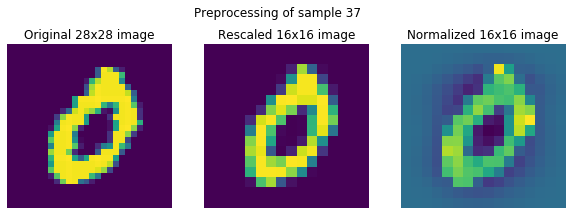

In [7]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, lists, titles):
    n_plots = len(lists)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(lists[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()
    
plot_comparison(37,
                [X_train, X_train_small, X_train_norm],
                [f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                 f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                 f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"])

In [8]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_norm.reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = X_test_norm.reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

# NEAT

## Basic Run Function

In [9]:
def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(50, filename_prefix='NEAT-checkpoints/neat-checkpoint-10-classes-'))
    
    
    # Run for up to NR_GENERATIONS generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)
    stats.save_genome_fitness(filename="NEAT-results/fitness_history.csv")
    
    with open('NEAT-results/best_genomes', 'wb') as f:
        best_genomes = stats.best_genomes(10)
        pickle.dump(best_genomes,f)
    
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))


## Basic Evaluation Function

In [10]:

def sigmoid(output):
    output = [min(709., x) for x in output]
    output = [max(-709., x) for x in output]
    return [1 /(1 + math.exp(-x)) for x in output]

In [11]:
def eval_genomes(genomes, config):
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    
    for genome_id, genome in genomes:
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = net.activate(train)
            if np.argmax(sigmoid(output)) == label:
                nr_correct += 1.

        genome.fitness = (nr_correct / N_SAMPLES_TO_TEST)          
    
        
        
#  OLD FITNESS:
#         for i in sample_indices:
#             train, label = X_train[i], Y_train[i]
#             output = net.activate(train)
#             genome.fitness -= (np.argmax(output) - label) ** 2 
 

In [12]:
run(CONFIG_FILE)


 ****** Running generation 0 ****** 

Population's average fitness: 0.10237 stdev: 0.03055
Best fitness: 0.20000 - size: (10, 256) - species 2 - id 84
Average adjusted fitness: 0.070
Mean genetic distance 2.820, standard deviation 0.353
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    67      0.2    0.075     0
     2    0    35      0.2    0.073     0
     3    0   155      0.2    0.066     0
     4    0    44      0.1    0.068     0
Total extinctions: 0
Generation time: 4.630 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.10877 stdev: 0.03808
Best fitness: 0.23000 - size: (10, 254) - species 3 - id 431
Average adjusted fitness: 0.087
Mean genetic distance 2.724, standard deviation 0.540
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   105      0.2    0.086     1
     2    1    76

Population's average fitness: 0.18542 stdev: 0.04321
Best fitness: 0.28000 - size: (10, 236) - species 3 - id 3595
Average adjusted fitness: 0.135
Mean genetic distance 2.787, standard deviation 0.769
Population of 301 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   12    40      0.3    0.116     4
     2   12    33      0.2    0.120     2
     3   12    45      0.3    0.148     0
     4   12    21      0.2    0.124     4
     5   11    53      0.3    0.156     3
     6    9    33      0.2    0.135     1
     7    7    50      0.2    0.142     5
     8    0    26       --       --     0
Total extinctions: 0
Generation time: 4.506 sec (4.505 average)

 ****** Running generation 13 ****** 

Population's average fitness: 0.16625 stdev: 0.04491
Best fitness: 0.30000 - size: (10, 240) - species 5 - id 3934
Average adjusted fitness: 0.112
Mean genetic distance 2.803, standard deviation 0.762
Population of 300 members in 8 spe

Population's average fitness: 0.20210 stdev: 0.04797
Best fitness: 0.34000 - size: (12, 225) - species 8 - id 6760
Average adjusted fitness: 0.129
Mean genetic distance 2.729, standard deviation 0.755
Population of 300 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   23    27      0.2    0.090     2
     2   23    33      0.2    0.112     6
     3   23    38      0.3    0.119     1
     4   23    55      0.3    0.131     6
     5   22    47      0.3    0.162     7
     6   20    24      0.3    0.136     3
     7   18    32      0.3    0.122    16
     8   11    44      0.3    0.159     0
Total extinctions: 0
Generation time: 4.609 sec (4.474 average)

 ****** Running generation 24 ****** 

Population's average fitness: 0.21187 stdev: 0.06190
Best fitness: 0.40000 - size: (10, 224) - species 5 - id 7127
Average adjusted fitness: 0.118
Mean genetic distance 2.741, standard deviation 0.780
Population of 299 members in 8 spe

Population's average fitness: 0.20870 stdev: 0.05718
Best fitness: 0.34000 - size: (13, 217) - species 8 - id 9612
Average adjusted fitness: 0.132
Mean genetic distance 2.912, standard deviation 0.855
Population of 300 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   34    30      0.2    0.092     8
     2   34    27      0.2    0.101    17
     3   34    45      0.3    0.159     7
     4   34    38      0.3    0.133    17
     5   33    55      0.3    0.200    10
     6   31    32      0.3    0.105    14
     7   29    30      0.2    0.100    10
     8   22    43      0.3    0.162    11
Total extinctions: 0
Generation time: 4.272 sec (4.394 average)

 ****** Running generation 35 ****** 

Population's average fitness: 0.20823 stdev: 0.04887
Best fitness: 0.32000 - size: (13, 225) - species 1 - id 10078
Average adjusted fitness: 0.136
Mean genetic distance 2.883, standard deviation 0.885
Population of 301 members in 8 sp

Mean genetic distance 2.875, standard deviation 0.954
Population of 301 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   45    43      0.3    0.141    19
     3   45    55      0.3    0.158    18
     4   45    52      0.3    0.158     3
     6   42    56      0.4    0.173     0
     7   40    42      0.2    0.105     3
     8   33    53      0.3    0.155     3
Total extinctions: 0
Generation time: 4.289 sec (4.493 average)

 ****** Running generation 46 ****** 

Population's average fitness: 0.22369 stdev: 0.05373
Best fitness: 0.34000 - size: (11, 208) - species 8 - id 13262

Species 1 with 43 members is stagnated: removing it
Average adjusted fitness: 0.136
Mean genetic distance 2.748, standard deviation 0.992
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3   46    64      0.3    0.148    19
     4   46    58      0.3    0.138     4
   

Population's average fitness: 0.22299 stdev: 0.04713
Best fitness: 0.35000 - size: (11, 204) - species 8 - id 17202
Average adjusted fitness: 0.122
Mean genetic distance 2.465, standard deviation 1.004
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4   59    89      0.3    0.126     3
     6   56    60      0.3    0.111    14
     7   54    77      0.3    0.126     2
     8   47    74      0.3    0.125    17
Total extinctions: 0
Generation time: 4.120 sec (4.061 average)

 ****** Running generation 60 ****** 

Population's average fitness: 0.20133 stdev: 0.04321
Best fitness: 0.30000 - size: (18, 219) - species 6 - id 17289
Average adjusted fitness: 0.132
Mean genetic distance 2.480, standard deviation 1.012
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4   60    86      0.3    0.133     4
     6   57    66      0.3    0.13

Population's average fitness: 0.21103 stdev: 0.04729
Best fitness: 0.32000 - size: (15, 193) - species 4 - id 21423
Average adjusted fitness: 0.121
Mean genetic distance 2.421, standard deviation 1.023
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4   74   147      0.3    0.119     7
     7   69   153      0.3    0.123     2
Total extinctions: 0
Generation time: 4.129 sec (4.061 average)

 ****** Running generation 75 ****** 

Population's average fitness: 0.19867 stdev: 0.04555
Best fitness: 0.31000 - size: (16, 183) - species 7 - id 21890
Average adjusted fitness: 0.119
Mean genetic distance 2.429, standard deviation 1.064
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4   75   148      0.3    0.118     8
     7   70   152      0.3    0.119     3
Total extinctions: 0
Generation time: 4.089 sec (4.068 average)

 ****** Run

Population's average fitness: 0.22007 stdev: 0.04853
Best fitness: 0.36000 - size: (13, 179) - species 4 - id 26021
Average adjusted fitness: 0.130
Mean genetic distance 2.363, standard deviation 1.023
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4   90   153      0.4    0.132    23
     7   85   147      0.3    0.128    18
Total extinctions: 0
Generation time: 3.896 sec (4.072 average)

 ****** Running generation 91 ****** 

Population's average fitness: 0.23687 stdev: 0.04955
Best fitness: 0.35000 - size: (15, 189) - species 4 - id 26619
Average adjusted fitness: 0.127
Mean genetic distance 2.347, standard deviation 0.970
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4   91   155      0.3    0.133    24
     7   86   145      0.3    0.121    19
Total extinctions: 0
Generation time: 3.934 sec (4.062 average)

 ****** Run

Population's average fitness: 0.23433 stdev: 0.04709
Best fitness: 0.37000 - size: (15, 172) - species 4 - id 30858
Average adjusted fitness: 0.174
Mean genetic distance 2.377, standard deviation 1.062
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  106   142      0.4    0.168    39
     7  101   158      0.3    0.180     3
Total extinctions: 0
Generation time: 3.745 sec (3.870 average)

 ****** Running generation 107 ****** 

Population's average fitness: 0.24937 stdev: 0.05305
Best fitness: 0.38000 - size: (17, 182) - species 7 - id 31095
Average adjusted fitness: 0.158
Mean genetic distance 2.354, standard deviation 1.032
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  107   136      0.3    0.137    40
     7  102   164      0.4    0.179     4
Total extinctions: 0
Generation time: 3.986 sec (3.881 average)

 ****** Ru

Population's average fitness: 0.26503 stdev: 0.06134
Best fitness: 0.43000 - size: (12, 159) - species 7 - id 35848
Average adjusted fitness: 0.155
Mean genetic distance 2.127, standard deviation 0.972
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  122   137      0.3    0.131     6
     7  117   163      0.4    0.178     6
Total extinctions: 0
Generation time: 3.682 sec (3.786 average)

 ****** Running generation 123 ****** 

Population's average fitness: 0.25337 stdev: 0.05160
Best fitness: 0.37000 - size: (11, 159) - species 7 - id 36028
Average adjusted fitness: 0.162
Mean genetic distance 2.155, standard deviation 1.023
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  123   136      0.3    0.148     7
     7  118   164      0.4    0.176     7
Total extinctions: 0
Generation time: 3.712 sec (3.759 average)

 ****** Ru

Population's average fitness: 0.26170 stdev: 0.05331
Best fitness: 0.40000 - size: (11, 154) - species 4 - id 40318
Average adjusted fitness: 0.142
Mean genetic distance 2.111, standard deviation 0.933
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  138   148      0.4    0.149    22
     7  133   152      0.4    0.136    22
Total extinctions: 0
Generation time: 3.576 sec (3.561 average)

 ****** Running generation 139 ****** 

Population's average fitness: 0.27517 stdev: 0.05523
Best fitness: 0.45000 - size: (13, 150) - species 4 - id 40365
Average adjusted fitness: 0.145
Mean genetic distance 2.068, standard deviation 0.962
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  139   160      0.5    0.167    23
     7  134   140      0.4    0.124    23
Total extinctions: 0
Generation time: 3.538 sec (3.548 average)

 ****** Ru

Population's average fitness: 0.27643 stdev: 0.05737
Best fitness: 0.45000 - size: (10, 141) - species 4 - id 45256
Average adjusted fitness: 0.155
Mean genetic distance 2.028, standard deviation 0.949
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  154   167      0.5    0.181    38
     7  149   133      0.4    0.129    38
Total extinctions: 0
Generation time: 3.457 sec (3.490 average)

 ****** Running generation 155 ****** 

Population's average fitness: 0.28737 stdev: 0.06533
Best fitness: 0.44000 - size: (10, 142) - species 4 - id 45595
Average adjusted fitness: 0.142
Mean genetic distance 2.126, standard deviation 0.904
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  155   182      0.4    0.187    39
     7  150   118      0.3    0.098    39
Total extinctions: 0
Generation time: 3.466 sec (3.491 average)

 ****** Ru

Population's average fitness: 0.29550 stdev: 0.06152
Best fitness: 0.44000 - size: (11, 138) - species 4 - id 49963
Average adjusted fitness: 0.154
Mean genetic distance 2.140, standard deviation 0.948
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  170   163      0.4    0.170    13
     7  165   137      0.4    0.138     8
Total extinctions: 0
Generation time: 3.399 sec (3.426 average)

 ****** Running generation 171 ****** 

Population's average fitness: 0.29577 stdev: 0.05344
Best fitness: 0.42000 - size: (10, 148) - species 7 - id 49758
Average adjusted fitness: 0.167
Mean genetic distance 2.165, standard deviation 0.968
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  171   151      0.4    0.154    14
     7  166   149      0.4    0.179     9
Total extinctions: 0
Generation time: 3.554 sec (3.446 average)

 ****** Ru

Population's average fitness: 0.28197 stdev: 0.06010
Best fitness: 0.40000 - size: (12, 146) - species 7 - id 54522
Average adjusted fitness: 0.181
Mean genetic distance 2.132, standard deviation 0.930
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  186   161      0.4    0.195     8
     7  181   139      0.4    0.167    13
Total extinctions: 0
Generation time: 3.377 sec (3.387 average)

 ****** Running generation 187 ****** 

Population's average fitness: 0.27243 stdev: 0.05262
Best fitness: 0.40000 - size: (12, 146) - species 7 - id 54522
Average adjusted fitness: 0.152
Mean genetic distance 2.114, standard deviation 0.928
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  187   160      0.4    0.162     9
     7  182   140      0.4    0.142    14
Total extinctions: 0
Generation time: 3.386 sec (3.388 average)

 ****** Ru

Population's average fitness: 0.29210 stdev: 0.05583
Best fitness: 0.44000 - size: (12, 128) - species 4 - id 59223
Average adjusted fitness: 0.230
Mean genetic distance 2.212, standard deviation 1.027
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  202   165      0.4    0.248     1
     7  197   135      0.4    0.211    29
Total extinctions: 0
Generation time: 3.358 sec (3.350 average)

 ****** Running generation 203 ****** 

Population's average fitness: 0.28340 stdev: 0.04940
Best fitness: 0.44000 - size: (12, 128) - species 4 - id 59223
Average adjusted fitness: 0.153
Mean genetic distance 2.133, standard deviation 1.002
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  203   160      0.4    0.157     2
     7  198   140      0.4    0.149    30
Total extinctions: 0
Generation time: 3.409 sec (3.358 average)

 ****** Ru

Population's average fitness: 0.30623 stdev: 0.05653
Best fitness: 0.44000 - size: (14, 137) - species 4 - id 64047
Average adjusted fitness: 0.186
Mean genetic distance 2.169, standard deviation 1.029
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  218   151      0.4    0.187    17
     7  213   149      0.4    0.185    45
Total extinctions: 0
Generation time: 3.403 sec (3.389 average)

 ****** Running generation 219 ****** 

Population's average fitness: 0.32817 stdev: 0.07009
Best fitness: 0.51000 - size: (14, 137) - species 4 - id 64047
Average adjusted fitness: 0.228
Mean genetic distance 2.179, standard deviation 1.020
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  219   150      0.5    0.229    18
     7  214   150      0.5    0.227     0
Total extinctions: 0
Generation time: 3.395 sec (3.392 average)

 ****** Ru

Population's average fitness: 0.32230 stdev: 0.06266
Best fitness: 0.48000 - size: (12, 121) - species 4 - id 68809
Average adjusted fitness: 0.152
Mean genetic distance 2.178, standard deviation 1.066
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  234   159      0.5    0.165    33
     7  229   141      0.5    0.139    15
Total extinctions: 0
Generation time: 3.490 sec (3.420 average)

 ****** Running generation 235 ****** 

Population's average fitness: 0.30447 stdev: 0.05470
Best fitness: 0.42000 - size: (14, 150) - species 7 - id 69088
Average adjusted fitness: 0.195
Mean genetic distance 2.185, standard deviation 0.996
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  235   154      0.4    0.193    34
     7  230   146      0.4    0.196    16
Total extinctions: 0
Generation time: 3.453 sec (3.426 average)

 ****** Ru


 ****** Running generation 250 ****** 

Population's average fitness: 0.30337 stdev: 0.05759
Best fitness: 0.49000 - size: (10, 129) - species 7 - id 73499
Average adjusted fitness: 0.144
Mean genetic distance 2.267, standard deviation 1.088
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  250   149      0.4    0.132    49
     7  245   151      0.5    0.156    31
Total extinctions: 0
Generation time: 3.331 sec (3.414 average)

 ****** Running generation 251 ****** 

Population's average fitness: 0.28973 stdev: 0.06373
Best fitness: 0.46000 - size: (10, 129) - species 7 - id 73499
Average adjusted fitness: 0.180
Mean genetic distance 2.244, standard deviation 1.095
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  251   141      0.4    0.159    50
     7  246   159      0.5    0.200    32
Total extinctions: 0
Generation ti

Population's average fitness: 0.29513 stdev: 0.05435
Best fitness: 0.44000 - size: (14, 129) - species 4 - id 78455
Average adjusted fitness: 0.165
Mean genetic distance 2.197, standard deviation 1.084
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  266   156      0.4    0.170    65
     7  261   144      0.4    0.160    47
Total extinctions: 0
Generation time: 3.473 sec (3.370 average)

 ****** Running generation 267 ****** 

Population's average fitness: 0.30153 stdev: 0.05430
Best fitness: 0.42000 - size: (14, 128) - species 4 - id 78720
Average adjusted fitness: 0.171
Mean genetic distance 2.200, standard deviation 1.067
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  267   157      0.4    0.179    66
     7  262   143      0.4    0.163    48
Total extinctions: 0
Generation time: 3.351 sec (3.350 average)

 ****** Ru

Population's average fitness: 0.29390 stdev: 0.05797
Best fitness: 0.45000 - size: (11, 122) - species 7 - id 83108
Average adjusted fitness: 0.143
Mean genetic distance 2.214, standard deviation 1.002
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  282   138      0.4    0.126    81
     7  277   162      0.5    0.160     5
Total extinctions: 0
Generation time: 3.536 sec (3.381 average)

 ****** Running generation 283 ****** 

Population's average fitness: 0.31697 stdev: 0.06678
Best fitness: 0.49000 - size: (11, 130) - species 7 - id 83478
Average adjusted fitness: 0.176
Mean genetic distance 2.217, standard deviation 0.990
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  283   139      0.4    0.162    82
     7  278   161      0.5    0.190     6
Total extinctions: 0
Generation time: 3.610 sec (3.409 average)

 ****** Ru

Population's average fitness: 0.31203 stdev: 0.05812
Best fitness: 0.46000 - size: (12, 113) - species 7 - id 87729
Average adjusted fitness: 0.152
Mean genetic distance 2.348, standard deviation 1.093
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  298   145      0.4    0.144    97
     7  293   155      0.5    0.159    21
Total extinctions: 0
Generation time: 3.442 sec (3.466 average)

 ****** Running generation 299 ****** 

Population's average fitness: 0.30877 stdev: 0.05866
Best fitness: 0.45000 - size: (12, 122) - species 7 - id 88145
Average adjusted fitness: 0.188
Mean genetic distance 2.293, standard deviation 1.100
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4  299   143      0.4    0.178    98
     7  294   157      0.5    0.199    22
Total extinctions: 0
Generation time: 3.391 sec (3.467 average)
Saving chec

## Plot History

In [13]:
history = np.genfromtxt('NEAT-results/fitness_history.csv', delimiter='')
best_fitness = history[:,0]
avg_fitness = history[:,1]

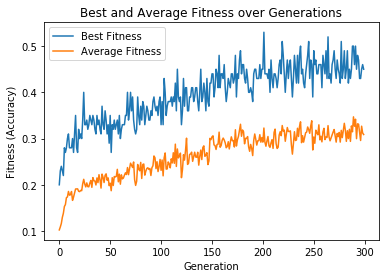

In [14]:
plt.plot(best_fitness, label = 'Best Fitness')
plt.plot(avg_fitness, label = 'Average Fitness')
plt.title('Best and Average Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.show()

## Load and Test Fittest Member

In [15]:
def test_fittest(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    preds_test = []
    preds_train = []
    train_correct = 0.
    test_correct = 0. 
    fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]
    #print(fittest_genome)
    net = neat.nn.FeedForwardNetwork.create(fittest_genome, config)
        
    for train, label in zip(X_train, Y_train):
        output = np.argmax(sigmoid(net.activate(train)))
        preds_train.append(output)
        if output == label:
            train_correct += 1.
    train_acc = train_correct / len(X_train)
    
    for test, label in zip(X_test, Y_test):
        output = np.argmax(sigmoid(net.activate(test)))
        preds_test.append(output)
        if output == label:
            test_correct += 1.
    test_acc = test_correct / len(X_test)
        
    print("Train Accuracy = {}".format(train_acc))
    print("Test Accuracy = {}".format(test_acc))
    
    return preds_train, preds_test

In [16]:
preds_train, preds_test = test_fittest(CONFIG_FILE)

Train Accuracy = 0.4130333333333333
Test Accuracy = 0.4186


In [17]:
cm_train = confusion_matrix(Y_train, preds_train, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, preds_test, labels=range(N_CLASSES_TO_USE))

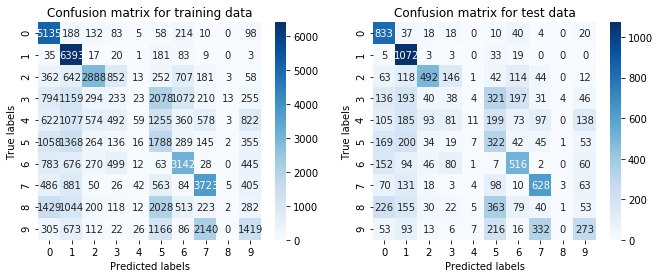

In [18]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for test data')

# Show the result
plt.show()

## Inspecting Fittest Genome

In [22]:
fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]

In [23]:
print(fittest_genome)

Key: 59146
Fitness: 0.53
Nodes:
	0 DefaultNodeGene(key=0, bias=1.0237591001848922, response=1.0, activation=identity, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-0.46554017926502406, response=1.0, activation=abs, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-0.1892288335656842, response=1.0, activation=identity, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=0.6430609911644886, response=1.0, activation=identity, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=-2.0707665712056476, response=1.0, activation=sin, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=0.9648331150675089, response=1.0, activation=identity, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=-0.2261657635217725, response=1.0, activation=identity, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=-0.9625183349235598, response=1.0, activation=identity, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=-1.4978870079977171, response=1.0, activation=gauss, aggregation=sum)
	9 DefaultNodeGene(key=9, bias=-0.4076568415801

In [24]:
used_input_pixels = []
for cg in fittest_genome.connections.values():
    if cg.enabled:
        used_input_pixels.append(cg.key[0])
print(used_input_pixels)

[-21, -115, -34, -22, -92, -18, -229, -8, -166, -4, -236, -130, -244, -122, -84, -116, -186, -217, -187, -171, -185, -120, -154, -72, -164, -6, -156, -71, -221, -117, -148, -5, -226, -19, -166, -75, -35, -111, -94, -10, -68, -8, -112, -123, -142, -137, -150, -118, -73, -148, -65, -73, -81, -49, -224, -87, -104, -105, -208, -160, -124, -122, -110, -33, -249, -109, -113, -40, -241, -241, -12, -57, -169, -185, -88, -22, -117, -118, -139, -38, -155, -3, -145, -186, -4, -3, -116, -25, -67, -17, -40, -219, -42, -175, -200, -52, -206, -128, -41, -165, -135, -104, -236, -189, -81, -92, -162, -22, -230, -138, -21, -50, -254, -232, -53, -15, -142, -157, -231, -96, -151, -197, -246, -198, -43, -127, -102, -82]


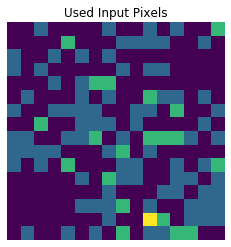

In [35]:
input_tallies = np.zeros(X_train.shape[1])
for arg in used_input_pixels:
    input_tallies[arg] += 1
plt.imshow( input_tallies.reshape(16,16) )
plt.title('Used Input Pixels')
plt.axis('off')
plt.show()